<a href="https://colab.research.google.com/github/goddess-1992/mm_idbm/blob/main/mm_bert_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **imports and downloads**

In [13]:
# Ensure kagglehub is installed at the very beginning
!pip install kagglehub

import os
import kagglehub
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import gc # For Python garbage collection
import copy # For deep copying model state_dicts
import matplotlib.pyplot as plt # For plotting
import torchvision.models as models

# --- KaggleHub Dataset Download ---
print("Downloading dataset using kagglehub...")
try:
    download_path = kagglehub.dataset_download("zulkarnainsaurav/imdb-multimodal-vision-and-nlp-genre-classification")
    print("Path to downloaded dataset root:", download_path)

    data_dir = os.path.join(download_path, "IMDB four_genre_posters")
    csv_file = os.path.join(download_path, "IMDB_four_genre_larger_plot_description.csv")

    print(f"Set data_dir to: {data_dir}")
    print(f"Set csv_file to: {csv_file}")

    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Error: Image directory not found at {data_dir}. Please check the path.")

    if not os.path.exists(csv_file):
        raise FileNotFoundError(f"Error: CSV file not found at {csv_file}. Please check the path.")

except Exception as e:
    print(f"An error occurred during dataset download or path configuration: {e}")
    print("Please ensure 'kagglehub' is installed and you have internet access.")
    raise

Path to downloaded dataset root: /kaggle/input/imdb-multimodal-vision-and-nlp-genre-classification
Set data_dir to: /kaggle/input/imdb-multimodal-vision-and-nlp-genre-classification/IMDB four_genre_posters
Set csv_file to: /kaggle/input/imdb-multimodal-vision-and-nlp-genre-classification/IMDB_four_genre_larger_plot_description.csv


# image and dataset **import**

In [14]:


# --- Configuration and Hyperparameters ---
image_size = (84, 84)
max_sequence_length = 375
embedding_dim = 200
DEPTH = 64
L2_REG_LAMBDA = 0.01

# --- Classification Specific Parameter ---
NUM_CLASSES = 4 # Comedy, Horror, Romance, Action

# --- Federated Learning Specific Parameters ---
NUM_CLIENTS = 5
LOCAL_EPOCHS = 5
COMMUNICATION_ROUNDS = 10
BATCH_SIZE = 16 # Adjust lower (e.g., 8, 4, 2) if OOM persists.

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Data Loading and Preprocessing ---
image_descriptions = {}
with open(csv_file, 'r') as csvfile:
    csv_reader = csv.DictReader(csvfile)
    for row in csv_reader:
        title = row['movie_id']
        description = row['description']
        image_descriptions[title] = description

# Define class_to_label globally
classes_list = ['Comedy', 'Horror', 'Romance', 'Action']
label_encoder_global = LabelEncoder()
label_encoder_global.fit(classes_list)
class_to_label = dict(zip(classes_list, label_encoder_global.transform(classes_list)))
print("Global Class to Label Mapping:")
print(class_to_label)

def load_image_pytorch(image_path, target_size=image_size):
    try:
        image = Image.open(image_path).convert('L') # Convert to grayscale
        transform = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor(), # Converts to [0, 1] and adds channel dimension
        ])
        image_tensor = transform(image)
        return image_tensor
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

def load_data_pytorch(directory):
    data = []
    dataID = []
    labels = []

    for class_name in classes_list: # Use the global list of classes
        path = os.path.join(directory, class_name)
        if not os.path.exists(path):
            print(f"Warning: Class directory not found: {path}. Skipping.")
            continue

        for image_filename in os.listdir(path):
            image_path = os.path.join(path, image_filename)
            image_tensor = load_image_pytorch(image_path)
            title = image_filename.split(".")[0]

            if image_tensor is not None:
                if title in image_descriptions:
                    data.append(image_tensor)
                    dataID.append(title)
                    label = label_encoder_global.transform([class_name])[0] # Use global encoder
                    labels.append(label)
    if not data:
        raise ValueError("No images or descriptions found. Check data paths and file structure.")
    return torch.stack(data), np.array(labels), np.array(dataID)

print("Loading data...")
try:
    data_images, data_labels, data_ids = load_data_pytorch(data_dir)
    print("Data loaded.")
except ValueError as e:
    print(f"Error during data loading: {e}")
    print("Please ensure the dataset is correctly downloaded and unzipped, and paths are correct.")
    raise

print("Processing descriptions...")
all_descriptions = [image_descriptions[id] for id in data_ids]

word_to_idx = {"<pad>": 0}
idx_counter = 1
sequences = []
for desc in all_descriptions:
    tokenized_desc = []
    for word in desc.lower().split():
        if word not in word_to_idx:
            word_to_idx[word] = idx_counter
            idx_counter += 1
        tokenized_desc.append(word_to_idx[word])
    sequences.append(tokenized_desc)

vocab_size = len(word_to_idx)
print("Vocabulary size:", vocab_size)

padded_sequences = np.zeros((len(sequences), max_sequence_length), dtype=int)
for i, seq in enumerate(sequences):
    length = min(len(seq), max_sequence_length)
    padded_sequences[i, :length] = seq[:length]

data_descriptions = torch.tensor(padded_sequences, dtype=torch.long)
print("Descriptions processed.")

print(f"Full image data shape: {data_images.shape}")
print(f"Full description data shape: {data_descriptions.shape}")
print(f"Full labels shape: {data_labels.shape}")

# Dataset split (centralized split for training and global val/test)
dataset_size = len(data_images)
np.random.seed(42) # For reproducibility
train_ratio = 0.8
# Split into training data for clients, and a global holdout set
indices = np.arange(dataset_size)
np.random.shuffle(indices)

train_size = int(dataset_size * train_ratio)
train_indices, global_holdout_indices = indices[:train_size], indices[train_size:]

train_images_all = data_images[train_indices]
train_descriptions_all = data_descriptions[train_indices]
train_labels_all = data_labels[train_indices]

# NEW: Split global_holdout_indices into validation and final test sets
# Let's use 50% for validation and 50% for test from the global_holdout_indices
if len(global_holdout_indices) < 2: # Ensure there are at least two samples to split
    raise ValueError("Not enough global holdout samples to split into validation and test sets.")

val_test_split_ratio = 0.5 # 50% for validation, 50% for test
val_size_global = int(len(global_holdout_indices) * val_test_split_ratio)
np.random.shuffle(global_holdout_indices) # Shuffle before splitting val/test

global_val_indices = global_holdout_indices[:val_size_global]
global_test_indices_final = global_holdout_indices[val_size_global:]

X_val_global = data_images[global_val_indices]
desc_val_global = data_descriptions[global_val_indices]
y_val_global = data_labels[global_val_indices]

X_test_global = data_images[global_test_indices_final]
desc_test_global = data_descriptions[global_test_indices_final]
y_test_global = data_labels[global_test_indices_final]


class MovieClassificationDataset(Dataset):
    def __init__(self, images, description_input_ids, description_attention_mask, labels):
        self.images = images
        self.description_input_ids = description_input_ids
        self.description_attention_mask = description_attention_mask
        self.labels = labels
        self.num_samples = len(images)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Return image, BERT input_ids, BERT attention_mask, and label
        return self.images[idx], \
               self.description_input_ids[idx], \
               self.description_attention_mask[idx], \
               torch.tensor(self.labels[idx], dtype=torch.long)


Using device: cuda
Global Class to Label Mapping:
{'Comedy': np.int64(1), 'Horror': np.int64(2), 'Romance': np.int64(3), 'Action': np.int64(0)}
Loading data...
Data loaded.
Processing descriptions...
Vocabulary size: 32618
Descriptions processed.
Full image data shape: torch.Size([724, 1, 84, 84])
Full description data shape: torch.Size([724, 375])
Full labels shape: (724,)


# model

In [15]:

import transformers # NEW: Import transformers library
BERT_OUTPUT_DIM = 768 # DistilBERT's default hidden size
BATCH_SIZE = 4 # Start with a very small batch size, e.g., 4 or even 2, 1.
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

class DescriptionEncoderBERT(nn.Module):
    def __init__(self, bert_model_name="distilbert-base-uncased", output_features=64, freeze_bert=True):
        super(DescriptionEncoderBERT, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        # Add a linear layer to map BERT's output (typically 768 for DistilBERT) to 64 features
        self.fc_out = nn.Linear(self.bert.config.hidden_size, output_features)
        self.relu = nn.ReLU() # Consistent with other encoder outputs

    def forward(self, input_ids, attention_mask):
        # BERT takes input_ids and attention_mask
        # output.last_hidden_state: (batch_size, sequence_length, hidden_size)
        # output.pooler_output: (batch_size, hidden_size) - this is the [CLS] token's pooled representation
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :] # Get the [CLS] token's embedding (first token)

        x = self.fc_out(pooled_output)
        x = self.relu(x)
        return x # This will be (batch_size, 64)


class ResNet50ImageEncoder(nn.Module):
    def __init__(self, output_features=64, freeze_pretrained=True):
        super(ResNet50ImageEncoder, self).__init__()
        resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        if freeze_pretrained:
            for param in resnet50.parameters():
                param.requires_grad = False

        self.features = nn.Sequential(*list(resnet50.children())[:-1])
        self.fc_out = nn.Linear(resnet50.fc.in_features, output_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc_out(x)
        x = self.relu(x)
        return x

class MultimodalClassificationNetwork(nn.Module):
    def __init__(self, input_size, depth, vocab_size, embedding_dim, lstm_hidden_dim=64, num_classes=4):
        super(MultimodalClassificationNetwork, self).__init__()
        self.image_encoder = ResNet50ImageEncoder(output_features=64) # Outputs 64 features
        # Use the new BERT encoder here
        self.description_encoder = DescriptionEncoderBERT(output_features=64) # Outputs 64 features

        # Concat features from ONE image (64) and ONE description (64) = 128
        self.fc1 = nn.Linear(64 + 64, 64)
        self.bn = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.dropout_final = nn.Dropout(p=0.5, inplace=False)
        self.output_layer = nn.Linear(64, num_classes)

    def forward(self, img, input_ids, attention_mask): # New: takes BERT inputs
        feature_vector_img = self.image_encoder(img)
        feature_vector_desc = self.description_encoder(input_ids, attention_mask) # Pass BERT inputs

        concat_features = torch.cat((feature_vector_img, feature_vector_desc), dim=1)

        x = self.fc1(concat_features)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout_final(x)
        output = self.output_layer(x)
        return output


print("Processing descriptions with BERT tokenizer...")
all_descriptions = [image_descriptions[id] for id in data_ids]

# Tokenize all descriptions at once
tokenized_outputs = tokenizer(
    all_descriptions,
    max_length=max_sequence_length, # Use the defined max_sequence_length
    padding='max_length',
    truncation=True,
    return_tensors="pt" # Return PyTorch tensors
)

data_descriptions_input_ids = tokenized_outputs['input_ids']
data_descriptions_attention_mask = tokenized_outputs['attention_mask']

print("Descriptions processed with BERT tokenizer.")
print(f"Tokenized input_ids shape: {data_descriptions_input_ids.shape}")
print(f"Attention mask shape: {data_descriptions_attention_mask.shape}")




Processing descriptions with BERT tokenizer...
Descriptions processed with BERT tokenizer.
Tokenized input_ids shape: torch.Size([724, 375])
Attention mask shape: torch.Size([724, 375])


# client and global federatel descriptions

In [46]:
class Client:
    def __init__(self, client_id, dataset, model_params):
        self.id = client_id
        self.local_model = MultimodalClassificationNetwork(
            input_size=image_size[0],
            depth=DEPTH,
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            lstm_hidden_dim=64, # This parameter is still passed but ignored by BERT encoder
            num_classes=NUM_CLASSES
        ).to(device)
        self.local_model.load_state_dict(model_params)
        self.data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,drop_last=True)
        self.optimizer = optim.Adam(self.local_model.parameters(), lr=0.001, weight_decay=L2_REG_LAMBDA)
        self.criterion = nn.CrossEntropyLoss()

    def receive_global_model(self, global_model_params):
        self.local_model.load_state_dict(global_model_params)
        self.optimizer = optim.Adam(self.local_model.parameters(), lr=0.001, weight_decay=L2_REG_LAMBDA)

    def train_local(self):
        self.local_model.train()
        max_batches_per_local_epoch = 100 # Adjust this based on client data size and desired local training.

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

        for epoch in range(LOCAL_EPOCHS):
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            num_batches_processed = 0

            # Inputs are now img, input_ids, attention_mask, labels
            for i, (img, input_ids, attention_mask, labels) in enumerate(self.data_loader):
                if num_batches_processed >= max_batches_per_local_epoch:
                    break

                img, input_ids, attention_mask, labels = img.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)

                self.optimizer.zero_grad()
                outputs = self.local_model(img, input_ids, attention_mask) # Pass all BERT inputs
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
                num_batches_processed += 1

            if total_train > 0:
                epoch_loss = running_loss / total_train
                epoch_acc = correct_train / total_train
                print(f"  Client {self.id} - Local Epoch {epoch+1}/{LOCAL_EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
            else:
                print(f"  Client {self.id} - Local Epoch {epoch+1}/{LOCAL_EPOCHS}, No training data processed for this epoch.")

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

        return self.local_model.state_dict(), epoch_loss, epoch_acc

def federated_average(client_models_state_dicts):
    if not client_models_state_dicts:
        return None

    avg_state_dict = copy.deepcopy(client_models_state_dicts[0])

    for key in avg_state_dict.keys():
        for i in range(1, len(client_models_state_dicts)):
            avg_state_dict[key] += client_models_state_dicts[i][key]
        avg_state_dict[key] = torch.div(avg_state_dict[key], len(client_models_state_dicts))
    return avg_state_dict



def evaluate_global_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

        max_eval_batches = 100
        num_batches_evaluated = 0

        # Inputs are now img, input_ids, attention_mask, labels
        for img, input_ids, attention_mask, labels in data_loader:
            if num_batches_evaluated >= max_eval_batches:
                break

            img, input_ids, attention_mask, labels = img.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(img, input_ids, attention_mask) # Pass all BERT inputs
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            num_batches_evaluated += 1

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

    if total == 0:
        return 0.0, 0.0

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


# dataset to clients

In [48]:
from collections import defaultdict

def partition_dataset_non_iid(
    data_images,
    data_descriptions_input_ids,
    data_descriptions_attention_mask,
    data_labels,
    num_clients=5,
    num_classes_per_client=2,
    batch_size=16,
    train_ratio=0.8,
    seed=42
):
    np.random.seed(seed)
    torch.manual_seed(seed)

    dataset_size = len(data_images)
    indices = np.arange(dataset_size)
    np.random.shuffle(indices)

    train_size = int(dataset_size * train_ratio)
    train_indices, global_holdout_indices = indices[:train_size], indices[train_size:]

    # Split global validation/test set
    val_size = len(global_holdout_indices) // 2
    global_val_indices = global_holdout_indices[:val_size]
    global_test_indices = global_holdout_indices[val_size:]

    X_val_global = data_images[global_val_indices]
    desc_val_input_ids = data_descriptions_input_ids[global_val_indices]
    desc_val_attention_mask = data_descriptions_attention_mask[global_val_indices]
    y_val_global = data_labels[global_val_indices]

    X_test_global = data_images[global_test_indices]
    desc_test_input_ids = data_descriptions_input_ids[global_test_indices]
    desc_test_attention_mask = data_descriptions_attention_mask[global_test_indices]
    y_test_global = data_labels[global_test_indices]

    # Group indices by class
    class_to_indices = defaultdict(list)
    for idx in train_indices:
        class_to_indices[data_labels[idx]].append(idx)

    all_classes = list(class_to_indices.keys())
    client_datasets = []

    print(f"\nCreating non-IID partitioning for {num_clients} clients...")
    for client_id in range(num_clients):
        chosen_classes = np.random.choice(all_classes, num_classes_per_client, replace=False)
        client_indices = []

        for cls in chosen_classes:
            cls_indices = class_to_indices[cls]
            num_samples = max(1, len(cls_indices) // num_clients)  # avoid empty sets
            sampled = np.random.choice(cls_indices, num_samples, replace=False)
            client_indices.extend(sampled)

            # Optional: remove assigned samples from pool (makes it disjoint)
            class_to_indices[cls] = list(set(cls_indices) - set(sampled))

        dataset = MovieClassificationDataset(
            data_images[client_indices],
            data_descriptions_input_ids[client_indices],
            data_descriptions_attention_mask[client_indices],
            data_labels[client_indices]
        )
        client_datasets.append(dataset)
        unique_labels = np.unique(data_labels[client_indices])
        print(f"Client {client_id+1}: {len(dataset)} samples | Classes: {unique_labels.tolist()}")

    global_val_dataset = MovieClassificationDataset(X_val_global, desc_val_input_ids, desc_val_attention_mask, y_val_global)
    global_val_loader = DataLoader(global_val_dataset, batch_size=batch_size, shuffle=False)

    global_test_dataset = MovieClassificationDataset(X_test_global, desc_test_input_ids, desc_test_attention_mask, y_test_global)
    global_test_loader = DataLoader(global_test_dataset, batch_size=batch_size, shuffle=False)

    return client_datasets, global_val_loader, global_test_loader, (
        X_test_global, desc_test_input_ids, desc_test_attention_mask, y_test_global
    )

def partition_dataset_for_federated_learning(
    data_images,
    data_descriptions_input_ids,
    data_descriptions_attention_mask,
    data_labels,
    train_ratio=0.8,
    num_clients=5,
    batch_size=16,
    seed=42
):
    np.random.seed(seed)

    dataset_size = len(data_images)
    indices = np.arange(dataset_size)
    np.random.shuffle(indices)

    train_size = int(dataset_size * train_ratio)
    train_indices, global_holdout_indices = indices[:train_size], indices[train_size:]

    # Split train
    train_images_all = data_images[train_indices]
    train_descriptions_input_ids_all = data_descriptions_input_ids[train_indices]
    train_descriptions_attention_mask_all = data_descriptions_attention_mask[train_indices]
    train_labels_all = data_labels[train_indices]

    # Validation/Test split
    val_test_split_ratio = 0.5
    if len(global_holdout_indices) < 2:
        raise ValueError("Not enough global holdout samples to split into validation and test sets.")

    np.random.shuffle(global_holdout_indices)
    val_size = int(len(global_holdout_indices) * val_test_split_ratio)
    global_val_indices = global_holdout_indices[:val_size]
    global_test_indices = global_holdout_indices[val_size:]

    X_val_global = data_images[global_val_indices]
    desc_val_input_ids = data_descriptions_input_ids[global_val_indices]
    desc_val_attention_mask = data_descriptions_attention_mask[global_val_indices]
    y_val_global = data_labels[global_val_indices]

    X_test_global = data_images[global_test_indices]
    desc_test_input_ids = data_descriptions_input_ids[global_test_indices]
    desc_test_attention_mask = data_descriptions_attention_mask[global_test_indices]
    y_test_global = data_labels[global_test_indices]

    # Partition train among clients
    print(f"\nPartitioning data for {num_clients} clients...")
    all_train_indices = np.arange(len(train_images_all))
    client_train_indices = np.array_split(all_train_indices, num_clients)
    client_datasets = []

    for i, indices in enumerate(client_train_indices):
        dataset = MovieClassificationDataset(
            train_images_all[indices],
            train_descriptions_input_ids_all[indices],
            train_descriptions_attention_mask_all[indices],
            train_labels_all[indices]
        )
        client_datasets.append(dataset)
        print(f"Client {i+1} has {len(dataset)} samples.")

    # Global validation/test loaders
    global_val_dataset = MovieClassificationDataset(X_val_global, desc_val_input_ids, desc_val_attention_mask, y_val_global)
    global_val_loader = DataLoader(global_val_dataset, batch_size=batch_size, shuffle=False)
    print(f"Global Validation set has {len(global_val_dataset)} samples.")

    global_test_dataset = MovieClassificationDataset(X_test_global, desc_test_input_ids, desc_test_attention_mask, y_test_global)
    global_test_loader = DataLoader(global_test_dataset, batch_size=batch_size, shuffle=False)
    print(f"Global Final Test set has {len(global_test_dataset)} samples.")

    return client_datasets, global_val_loader, global_test_loader, (
        X_test_global, desc_test_input_ids, desc_test_attention_mask, y_test_global
    )



#iid

# client_datasets, global_val_loader, global_test_loader_final, test_data_tuple = partition_dataset_for_federated_learning(
#     data_images, data_descriptions_input_ids, data_descriptions_attention_mask, data_labels,
#     train_ratio=0.8, num_clients=NUM_CLIENTS, batch_size=BATCH_SIZE
# )

#non-iid

client_datasets, global_val_loader, global_test_loader_final, test_data_tuple = partition_dataset_non_iid(
    data_images, data_descriptions_input_ids, data_descriptions_attention_mask, data_labels,
    num_clients=NUM_CLIENTS, num_classes_per_client=2, batch_size=BATCH_SIZE
)

X_test_global, desc_test_global_input_ids, desc_test_global_attention_mask, y_test_global = test_data_tuple



Creating non-IID partitioning for 5 clients...
Client 1: 33 samples | Classes: [1, 3]
Client 2: 27 samples | Classes: [1, 3]
Client 3: 51 samples | Classes: [2, 3]
Client 4: 47 samples | Classes: [0, 3]
Client 5: 39 samples | Classes: [2, 3]


In [40]:
for i, dataset in enumerate(client_datasets):
    if len(dataset) < BATCH_SIZE:
        print(f"⚠️ Client {i+1} has only {len(dataset)} samples — BATCH_SIZE = {BATCH_SIZE}")


# initialize

In [49]:
# --- Initialize Global Model (using MultimodalClassificationNetwork) ---
global_model = MultimodalClassificationNetwork(
    input_size=image_size[0],
    depth=DEPTH,
    vocab_size=vocab_size, # This is technically not used by BERT encoder
    embedding_dim=embedding_dim, # This is technically not used by BERT encoder
    lstm_hidden_dim=64, # This is technically not used by BERT encoder
    num_classes=NUM_CLASSES
).to(device)

clients = []
for i, dataset in enumerate(client_datasets):
    client = Client(i + 1, dataset, global_model.state_dict())
    clients.append(client)
print(f"Initialized {len(clients)} clients.")

# --- Federated Learning Training Loop ---
print("\n--- Starting Federated Learning Training ---")
best_global_val_loss = float('inf') # Use validation loss for early stopping / best model saving
global_model_save_path = '/content/best_global_model_pytorch_fl.pth'

# Lists to store metrics for plotting
global_history_val_loss = []
global_history_val_accuracy = []
global_history_test_loss = []
global_history_test_accuracy = []
clients_history_loss = {f'Client {i+1}': [] for i in range(len(client_datasets))}
clients_history_accuracy = {f'Client {i+1}': [] for i in range(len(client_datasets))}


if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

Initialized 5 clients.

--- Starting Federated Learning Training ---


# run


Communication Round 1/10
  Client 1 starting local training...
  Client 1 - Local Epoch 1/5, Loss: 1.5883, Accuracy: 0.2188
  Client 1 - Local Epoch 2/5, Loss: 1.2982, Accuracy: 0.4062
  Client 1 - Local Epoch 3/5, Loss: 1.1147, Accuracy: 0.5625
  Client 1 - Local Epoch 4/5, Loss: 1.0627, Accuracy: 0.5000
  Client 1 - Local Epoch 5/5, Loss: 0.8811, Accuracy: 0.7812
  Client 2 starting local training...
  Client 2 - Local Epoch 1/5, Loss: 1.5487, Accuracy: 0.2083
  Client 2 - Local Epoch 2/5, Loss: 1.4170, Accuracy: 0.3333
  Client 2 - Local Epoch 3/5, Loss: 1.3207, Accuracy: 0.2500
  Client 2 - Local Epoch 4/5, Loss: 1.1145, Accuracy: 0.5000
  Client 2 - Local Epoch 5/5, Loss: 0.8875, Accuracy: 0.7500
  Client 3 starting local training...
  Client 3 - Local Epoch 1/5, Loss: 1.3565, Accuracy: 0.3750
  Client 3 - Local Epoch 2/5, Loss: 1.0165, Accuracy: 0.6667
  Client 3 - Local Epoch 3/5, Loss: 0.7911, Accuracy: 0.7500
  Client 3 - Local Epoch 4/5, Loss: 0.6045, Accuracy: 0.8750
  Clie

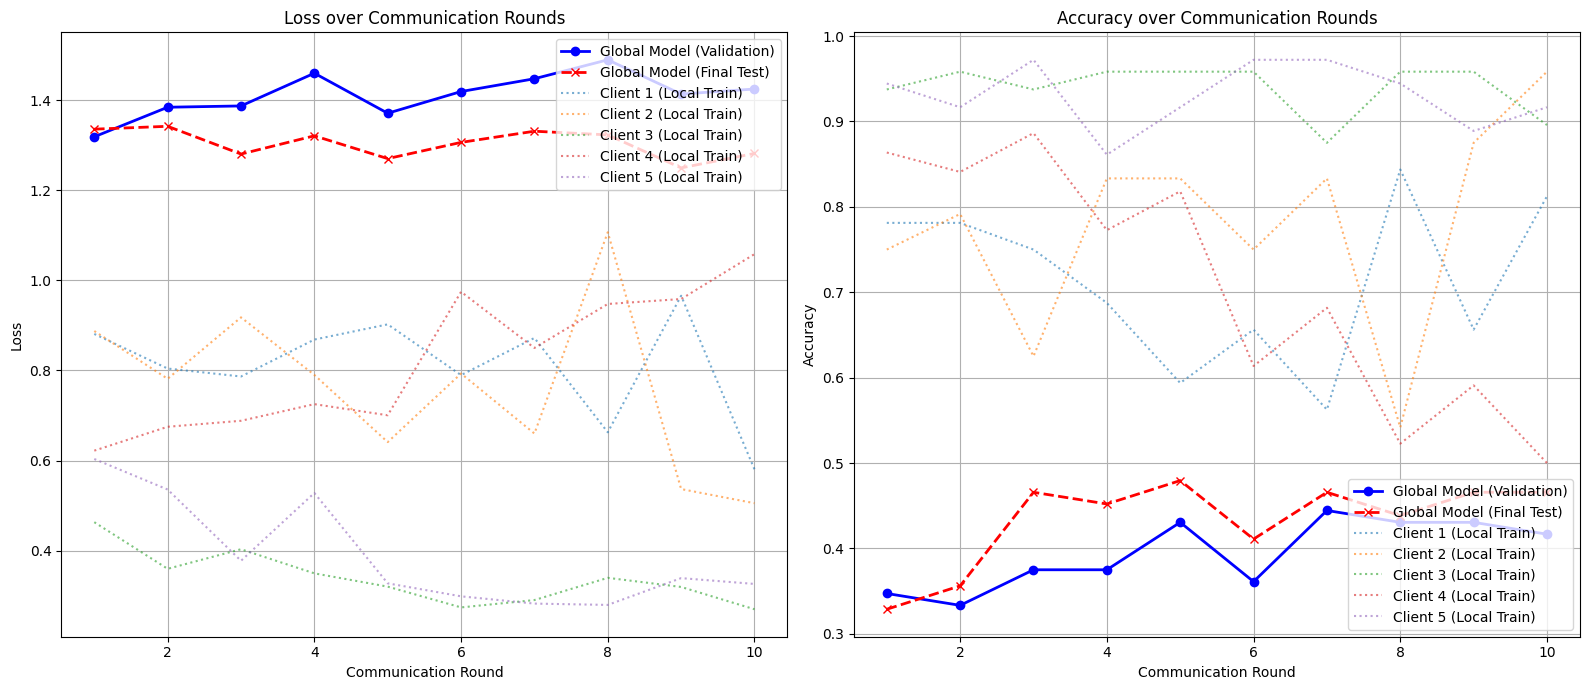


--- Plotting a Sample Prediction Output ---


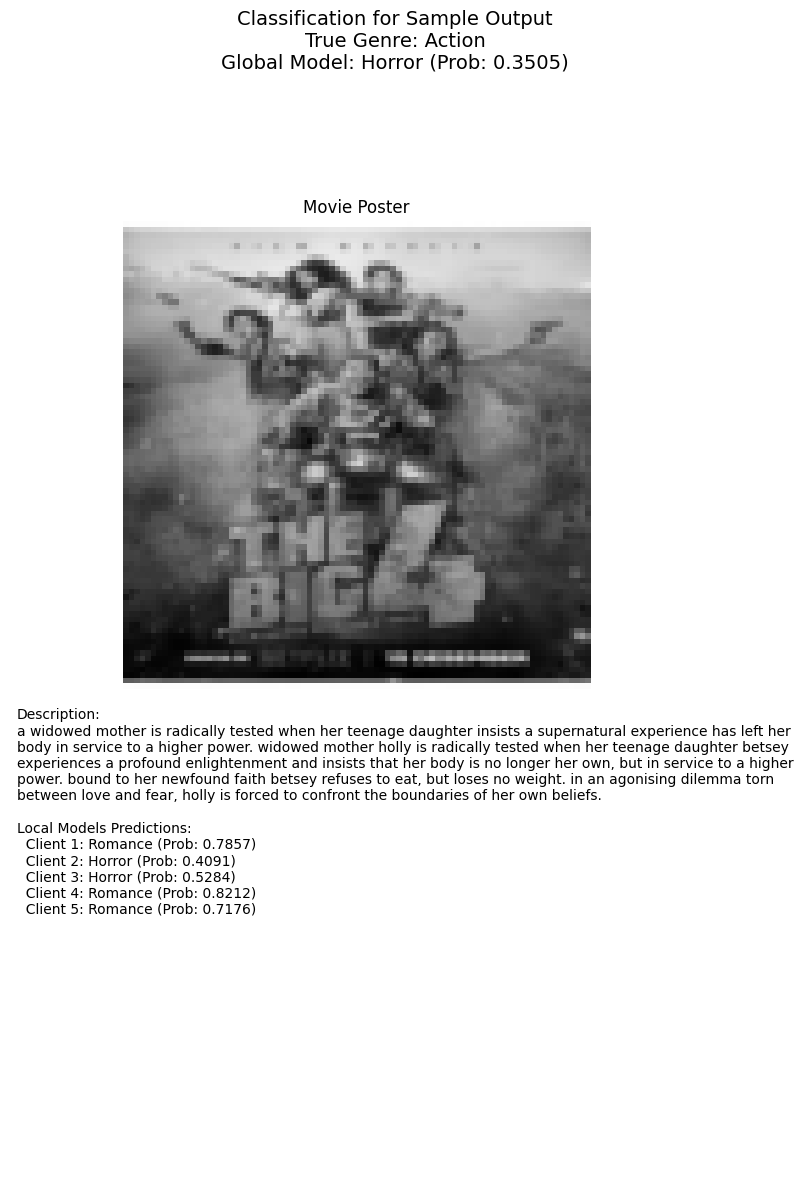

Final global model saved to /content/final_global_model_pytorch_fl.pth


In [50]:

for round_num in range(COMMUNICATION_ROUNDS):
    print(f"\nCommunication Round {round_num + 1}/{COMMUNICATION_ROUNDS}")

    for client in clients:
        client.receive_global_model(global_model.state_dict())

    client_updates = []
    for idx, client in enumerate(clients):
        print(f"  Client {client.id} starting local training...")
        updated_state_dict, local_loss, local_acc = client.train_local()
        client_updates.append(updated_state_dict)
        clients_history_loss[f'Client {client.id}'].append(local_loss)
        clients_history_accuracy[f'Client {client.id}'].append(local_acc)

    print("Aggregating client models...")
    aggregated_state_dict = federated_average(client_updates)
    global_model.load_state_dict(aggregated_state_dict)
    print("Global model updated.")

    # Evaluate global model on Validation set
    val_loss_round, val_acc_round = evaluate_global_model(global_model, global_val_loader, nn.CrossEntropyLoss())
    print(f"Global Model - Validation Loss: {val_loss_round:.4f}, Validation Accuracy: {val_acc_round:.4f}")

    # Evaluate global model on Final Test set
    test_loss_round, test_acc_round = evaluate_global_model(global_model, global_test_loader_final, nn.CrossEntropyLoss())
    print(f"Global Model - Final Test Loss: {test_loss_round:.4f}, Final Test Accuracy: {test_acc_round:.4f}")

    # Store global metrics for plotting
    global_history_val_loss.append(val_loss_round)
    global_history_val_accuracy.append(val_acc_round)
    global_history_test_loss.append(test_loss_round)
    global_history_test_accuracy.append(test_acc_round)

    # Use validation loss for best model saving
    if val_loss_round < best_global_val_loss:
        best_global_val_loss = val_loss_round
        torch.save(global_model.state_dict(), global_model_save_path)
        print(f"Best global model saved with validation loss: {best_global_val_loss:.4f}")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

print("\n--- Federated Learning Training Finished ---")

# --- Final Evaluation (on best saved model) ---
if os.path.exists(global_model_save_path):
    global_model.load_state_dict(torch.load(global_model_save_path))
    print(f"Loaded best global model from {global_model_save_path}")
else:
    print("No best global model saved. Using the last trained global model.")

final_val_loss, final_val_accuracy = evaluate_global_model(global_model, global_val_loader, nn.CrossEntropyLoss())
final_test_loss, final_test_accuracy = evaluate_global_model(global_model, global_test_loader_final, nn.CrossEntropyLoss())
print(f"\nFinal Global Model Performance (Best Model):")
print(f"Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.4f}")


# --- Plotting Training History (Global Val/Test vs Clients Local Train) ---
print("\n--- Generating Plots ---")
rounds = range(1, COMMUNICATION_ROUNDS + 1)

plt.figure(figsize=(16, 7))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(rounds, global_history_val_loss, marker='o', linestyle='-', label='Global Model (Validation)', color='blue', linewidth=2)
plt.plot(rounds, global_history_test_loss, marker='x', linestyle='--', label='Global Model (Final Test)', color='red', linewidth=2)
for client_id, losses in clients_history_loss.items():
    plt.plot(rounds, losses, linestyle=':', alpha=0.6, label=f'{client_id} (Local Train)')
plt.title('Loss over Communication Rounds')
plt.xlabel('Communication Round')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(rounds, global_history_val_accuracy, marker='o', linestyle='-', label='Global Model (Validation)', color='blue', linewidth=2)
plt.plot(rounds, global_history_test_accuracy, marker='x', linestyle='--', label='Global Model (Final Test)', color='red', linewidth=2)
for client_id, accuracies in clients_history_accuracy.items():
    plt.plot(rounds, accuracies, linestyle=':', alpha=0.6, label=f'{client_id} (Local Train)')
plt.title('Accuracy over Communication Rounds')
plt.xlabel('Communication Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))

plt.tight_layout()
plt.show()

# --- Plotting a Sample Prediction Output (for multi-class classification) ---
print("\n--- Plotting a Sample Prediction Output ---")

if len(X_test_global) < 1:
    print("Not enough global test samples to plot a single prediction. Need at least 1 sample.")
else:
    np.random.seed(42) # For reproducibility of the sample output plot
    idx = np.random.choice(len(X_test_global), 1, replace=False)[0]

    img_display = X_test_global[idx].squeeze().cpu().numpy()

    desc_words = []
    # Reverse lookup for word_to_idx is correct
    reverse_word_map = {v: k for k, v in word_to_idx.items()}
    for token_id in desc_test_global[idx].cpu().numpy():
        if token_id == 0: # Pad token is 0
            break
        desc_words.append(reverse_word_map.get(token_id, '<unk>')) # Use .get with <unk> for robustness
    desc_full_text = ' '.join(desc_words[:100]) + '...' if len(desc_words) > 100 else ' '.join(desc_words)


    img_model = X_test_global[idx].unsqueeze(0).to(device)
    desc_model_input_ids = desc_test_global[idx].unsqueeze(0).to(device)
    desc_model_attention_mask = torch.ones_like(desc_model_input_ids).to(device) # Create attention mask for single sample

    true_label_id = y_test_global[idx]
    reverse_label_map = {v: k for k, v in class_to_label.items()}
    true_label_text = reverse_label_map.get(true_label_id, 'Unknown')


    global_model.eval()
    with torch.no_grad():
        outputs_global = global_model(img_model, desc_model_input_ids, desc_model_attention_mask) # Pass attention mask
        predicted_prob_raw_global = torch.softmax(outputs_global, dim=1)
        predicted_prob_value_global, predicted_class_id_global = torch.max(predicted_prob_raw_global, 1)

    predicted_class_text_global = reverse_label_map.get(predicted_class_id_global.item(), 'Unknown')
    predicted_prob_for_class_global = predicted_prob_value_global.item()

    # --- Predictions from Local Models ---
    local_predictions_text = []
    # Recreate local models for prediction if they are not stored directly, or load from saved state dicts
    # In a real FL setup, you wouldn't load all client models to the server.
    # For this simulation, we access the 'clients' objects which hold their local_model.
    for client_obj in clients:
        client_model = client_obj.local_model
        client_model.eval()
        with torch.no_grad():
            outputs_local = client_model(img_model, desc_model_input_ids, desc_model_attention_mask) # Pass attention mask
            predicted_prob_raw_local = torch.softmax(outputs_local, dim=1)
            predicted_prob_value_local, predicted_class_id_local = torch.max(predicted_prob_raw_local, 1)

        predicted_class_text_local = reverse_label_map.get(predicted_class_id_local.item(), 'Unknown')
        predicted_prob_for_class_local = predicted_prob_value_local.item()

        local_predictions_text.append(
            f"  Client {client_obj.id}: {predicted_class_text_local} (Prob: {predicted_prob_for_class_local:.4f})"
        )

    plt.figure(figsize=(8, 12))

    plt.subplot(2, 1, 1)
    plt.imshow(img_display, cmap='gray')
    plt.title('Movie Poster')
    plt.axis('off')

    plt.suptitle(f"Classification for Sample Output\n"
                 f"True Genre: {true_label_text}\n"
                 f"Global Model: {predicted_class_text_global} (Prob: {predicted_prob_for_class_global:.4f})",
                 fontsize=14, y=0.98)

    plt.subplot(2, 1, 2)
    desc_display_text = f"Description:\n{desc_full_text}\n\n"
    local_models_summary = "Local Models Predictions:\n" + "\n".join(local_predictions_text)
    full_text_to_display = desc_display_text + local_models_summary

    plt.text(0.01, 0.99, full_text_to_display,
             verticalalignment='top', horizontalalignment='left',
             fontsize=10, wrap=True)
    plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

torch.save(global_model.state_dict(), '/content/final_global_model_pytorch_fl.pth')
print("Final global model saved to /content/final_global_model_pytorch_fl.pth")